In [2]:

from langchain_groq import ChatGroq


from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

d:\DATA SCIENCE PROJECTS\LANGGRAPH - CHATBOT\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

import os
os.environ["GROQ_API_KEY"] = "**************************"


In [4]:

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.3
)

In [5]:


def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}


# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)


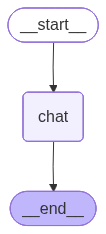

In [6]:
app

In [7]:

# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [8]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='195eba2a-366c-4605-907c-80114a9fdbc9')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='0dd07fed645516e7ae71c98482e534b9')]}

In [9]:

message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [10]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [11]:

# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [12]:
final_result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='195eba2a-366c-4605-907c-80114a9fdbc9'),
  AIMessage(content='**Gradient Descent in Simple Terms**\n\nImagine you\'re trying to find the lowest point in a big valley. You can\'t see the bottom, but you know it\'s there. You start at the top of the valley and take small steps downhill, adjusting your direction slightly each time based on how steep the slope is.\n\n**How Gradient Descent Works:**\n\n1. **Start at a random point**: You begin at a random point in the valley (or a mathematical function).\n2. **Measure the slope**: You measure how steep the slope is at your current point. This is like looking at the angle of the hill.\n3. **Take a small step**: You take a small step downhill, based on the slope you measured. If the slope is very steep, you take a bigger step.\n4. **Repeat steps 2-3**: You keep measuring the slope and taking small steps downhill 

In [25]:
from langgraph.graph import StateGraph, START
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.types import interrupt, Command


In [29]:
import requests

@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = (
        "https://www.alphavantage.co/query"
        f"?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    )
    r = requests.get(url)
    return r.json()


@tool
def purchase_stock(symbol: str, quantity: int) -> dict:
    """
    Simulate purchasing a given quantity of a stock symbol.

    HUMAN-IN-THE-LOOP:
    Before confirming the purchase, this tool will interrupt
    and wait for a human decision ("yes" / anything else).
    """
    # This pauses the graph and returns control to the caller
    decision = interrupt(f"Approve buying {quantity} shares of {symbol}? (yes/no)")

    if isinstance(decision, str) and decision.lower() == "yes":
        return {
            "status": "success",
            "message": f"Purchase order placed for {quantity} shares of {symbol}.",
            "symbol": symbol,
            "quantity": quantity,
        }
    
    else:
        return {
            "status": "cancelled",
            "message": f"Purchase of {quantity} shares of {symbol} was declined by human.",
            "symbol": symbol,
            "quantity": quantity,
        }
    
SYSTEM_PROMPT = SystemMessage(
    content="""
You are an AI assistant with access to tools.

STRICT RULES:
1. DO NOT call any tool unless the user explicitly asks for:
   - real-time data (prices, APIs, status)
   - an action (buy, submit, approve, fetch, calculate)
2. For normal questions, explanations, or chit-chat:
   - respond directly in plain text
   - DO NOT use tools
3. Use tools ONLY when absolutely required.
4. If unsure, ASK a clarification question instead of calling a tool.
"""
)


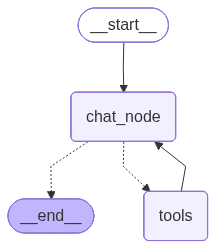

In [ ]:

tools = [get_stock_price, purchase_stock]
llm_with_tools = llm.bind_tools(tools)

TOOL_KEYWORDS = {
    "price", "buy", "purchase", "stock",
    "fetch", "get", "check", "approve", "calculate"
}

def tool_needed(messages):
    last = messages[-1].content.lower()
    return any(k in last for k in TOOL_KEYWORDS)

# -------------------
# 3. State
# -------------------
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# -------------------
# 4. Nodes
# -------------------
def chat_node(state: ChatState):
    
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)

# -------------------
# 5. Checkpointer (in-memory)
# -------------------
memory = MemorySaver()

# -------------------
# 6. Graph
# -------------------
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile(checkpointer=memory)

chatbot

In [28]:
# -------------------
# 7. Simple usage example (CLI with HITL)
# -------------------
if __name__ == "__main__":
    # Use a fixed thread_id so the conversation is persisted in memory
    thread_id = "demo-thread"

    while True:
        user_input = input("You: ")
        if user_input.lower().strip() in {"exit", "quit"}:
            print("Goodbye!")
            break

    # Build initial state for this turn
    state = {"messages": [HumanMessage(content=user_input)]}

    # Run the graph (may hit an interrupt)
    result = chatbot.invoke(
        state,
        config={"configurable": {"thread_id": thread_id}},
    )

    # Check for HITL interrupt from purchase_stock
    interrupts = result.get("__interrupt__", [])

    if interrupts:
        # Our interrupt payload is the string we passed to interrupt(...)
        prompt_to_human = interrupts[0].value
        print(f"HITL: {prompt_to_human}")
        decision = input("Your decision: ").strip().lower()

        # Resume graph with the human decision ("yes" / "no" / whatever)
        result = chatbot.invoke(
            Command(resume=decision),
            config={"configurable": {"thread_id": thread_id}},
        )

    # Get the latest message from the assistant
    messages = result["messages"]
    last_msg = messages[-1]
    print(f"Bot: {last_msg.content}\n")
    

Goodbye!


ValueError: Invalid input type <class 'langchain_core.prompts.chat.ChatPromptTemplate'>. Must be a PromptValue, str, or list of BaseMessages.